In [1]:
import torch
import os
import glob
import matplotlib.pyplot as plt

import queue

import threading

from tqdm.notebook import tqdm

from collections import namedtuple

import time

import random

from copy import deepcopy

from scipy.ndimage import gaussian_filter

In [2]:
import cv2 
import numpy as np
from PIL import Image

In [3]:
import torch
import torch.functional as F
import torch.nn as nn

In [4]:
Batch = namedtuple('batch', ('before', 'after'))

In [5]:
emoticon_file_list = glob.glob('resource/*.png')
emoticon_file_list.sort()

In [6]:
# image = cv2.imread(emoticon_file_list[-1])
# image = image[:, :, (2, 1, 0)]
# image = image / 2 ** 8
# plt.imshow(image)

BATCH_SIZE = 4
BATCH_SIZE = 16
BATCH_SIZE = 32

In [7]:
def punch_image(image, p=0.1):
    
    bool_mask = np.random.choice((True, False), image.shape[1:3], True, (1-p, p))
    bool_mask = np.stack([bool_mask, bool_mask, bool_mask], axis=0)
    
    punched_image= np.where(bool_mask, image, np.ones(image.shape))
    
    return punched_image

def blur_image(image, sigma=0.25):
    blurred_image = gaussian_filter(image, sigma = (0, sigma, sigma))
    return blurred_image

def create_cross_mask(size):
    
    assert size % 2 == 1, 'Cross mask supports only odd sized matrix'
    
    mask_matrix = np.zeros((size, size), dtype=bool)
    
    center = np.array((size // 2, size // 2))
    
    for point in [np.array((i, j)) for i in range(size) for j in range(size)]:
        if np.sum(np.fabs(center - point)) <= size // 2:
            mask_matrix[point[0], point[1]] = True
    
    return mask_matrix

def apply_mask_to_image(image, mask_matrix, offset=(0, 0)):
    
    image_length = image.shape[1] // 2
    mask_length = mask_matrix.shape[0]
    mask_half_length = mask_length // 2
    
    full_mask = np.zeros((image.shape[1] + mask_length, \
                          image.shape[2] + mask_length), dtype=bool)
    
    center = (full_mask.shape[0] // 2, full_mask.shape[1] // 2)
    
    x_min = center[0] + offset[0] - mask_half_length
    x_max = center[0] + offset[0] + mask_half_length + 1
    y_min = center[1] + offset[1] - mask_half_length
    y_max = center[1] + offset[1] + mask_half_length + 1
    
    try:
        full_mask[x_min:x_max,y_min:y_max] = mask_matrix
    except:
        print(x_min, x_max, y_min, y_max, offset)
    full_mask = full_mask[center[0] - image_length:center[0] + image_length,
                          center[0] - image_length:center[0] + image_length]
    
    bool_mask = np.stack([full_mask, full_mask, full_mask], axis=0)
    
    masked_image= np.where(bool_mask, image, np.ones(image.shape), )
    
    return masked_image

In [8]:
mask_list = [create_cross_mask(i) for i in tqdm(range(7, 7 + 4 * 7 * 7, 4))]

In [9]:
def batch_list_to_tensor_batch(batch_list):
    try:
        before_batch = np.stack([batch_tuple[0] for batch_tuple in batch_list], axis=0)
        after_batch = np.stack([batch_tuple[1] for batch_tuple in batch_list], axis=0)
    except:
        [print(batch_tuple[0].shape) for batch_tuple in batch_list]
        [print(batch_tuple[1].shape) for batch_tuple in batch_list]
    return (torch.tensor(before_batch, dtype=torch.float32), torch.tensor(after_batch, dtype=torch.float32))


class GeneralImageFeeder:
    
    def __init__(self, file_list):
        self.file_list = file_list
        self.queue = queue.Queue(maxsize=100)
#         self.num_type = 3
        self.finished = [True, True, False] # self.finished = [False, False, False]
        self.batch_size = BATCH_SIZE
        self.punch_iter_num = 3
        self.blur_iter_num = 6
        self.growth_iter_num = 49
        self.growth_step = 4
        self.mask_list = [create_cross_mask(i) for i in \
                          tqdm(range(7, 7 + self.growth_step * self.growth_iter_num, self.growth_step))]
#         self.max_batch_num = int(np.floor(( \
#                                   len(self.file_list) * (self.punch_iter_num + 1) + \
#                                   len(self.file_list) * (self.blur_iter_num + 1)) \
#                               / self.batch_size))
        self.max_batch_num = int(np.ceil(( \
                                  len(self.file_list) * (self.growth_iter_num - 1)) 
                              / self.batch_size))
        
        
    def start_feeding_punch(self):
        
        batch_tuple_list = []
        
        for file in self.file_list:
            image = cv2.imread(file)
            image = image[:, :, (2, 1, 0)]
            image = image / 2 ** 8
            image = np.rollaxis(image, 2, 0)
            
            image_origin = deepcopy(image)
            
            batch_tuple_list.append(Batch(image, image))
            
            for j in range(self.punch_iter_num):
                punched_image = punch_image(image, 0.1 * (j + 1))
                batch_tuple_list.append(Batch(punched_image, image))
                
                if len(batch_tuple_list) >= self.batch_size:
                    random.shuffle(batch_tuple_list)
                    batch = batch_list_to_tensor_batch(batch_tuple_list)
                    self.queue.put(batch)
                    batch_tuple_list = list()
                
        if len(batch_tuple_list) > 0:
            random.shuffle(batch_tuple_list)
            batch = batch_list_to_tensor_batch(batch_tuple_list)
            self.queue.put(batch)
            batch_tuple_list = list()
                
        self.finished[0] = True
        
    def start_feeding_blur(self):
        
        batch_tuple_list = []
        
        for file in self.file_list:
            image = cv2.imread(file)
            image = image[:, :, (2, 1, 0)]
            image = image / 2 ** 8
            image = np.rollaxis(image, 2, 0)
            
            image_origin = deepcopy(image)
            
            batch_tuple_list.append(Batch(image, image))
            
            for j in range(self.blur_iter_num):
                blurred_image = blur_image(image, 0.25 * (j + 1))
                batch_tuple_list.append(Batch(blurred_image, image))
                
                if len(batch_tuple_list) >= self.batch_size:
                    random.shuffle(batch_tuple_list)
                    batch = batch_list_to_tensor_batch(batch_tuple_list)
                    self.queue.put(batch)
                    batch_tuple_list = list()
                
        if len(batch_tuple_list) > 0:
            random.shuffle(batch_tuple_list)
            batch = batch_list_to_tensor_batch(batch_tuple_list)
            self.queue.put(batch)
            batch_tuple_list = list()
                
        self.finished[1] = True
        
    def start_feeding_growth(self):
        
        batch_tuple_list = []
        
        for file in self.file_list:
            image = cv2.imread(file)
            image = image[:, :, (2, 1, 0)]
            image = image / 2 ** 8
            image = np.rollaxis(image, 2, 0)
            
            seed_position = (int(min(max(np.random.normal(0, image.shape[1]/6), \
                                        -image.shape[1]/2), image.shape[1]/2)), \
                             int(min(max(np.random.normal(0, image.shape[2]/6), \
                                        -image.shape[2]/2), image.shape[2]/2)))
            
            growing_images = list()
            
            for j, mask in enumerate(mask_list):
                growing_images.append(apply_mask_to_image(image, mask, seed_position))

            for j, cell_image in enumerate(growing_images[:-1]):
                
                batch_tuple_list.append(Batch(cell_image, growing_images[j+1]))
                
                if len(batch_tuple_list) >= self.batch_size:
                    random.shuffle(batch_tuple_list)
                    batch = batch_list_to_tensor_batch(batch_tuple_list)
                    self.queue.put(batch)
                    batch_tuple_list = list()
                
        if len(batch_tuple_list) > 0:
            random.shuffle(batch_tuple_list)
            batch = batch_list_to_tensor_batch(batch_tuple_list)
            self.queue.put(batch)
            batch_tuple_list = list()
                
        self.finished[2] = True
             
    def generator(self):
        
#         self.finished = [False for i in range(len(self.finished))]
        self.finished = [True, True, False]
        random.shuffle(self.file_list)
        
#         t1 = threading.Thread(target=self.start_feeding_punch)
#         t2 = threading.Thread(target=self.start_feeding_blur)
        t3 = threading.Thread(target=self.start_feeding_growth)
        
#         t1.start()
#         t2.start()
        t3.start()
        
        while not (all(self.finished) and self.queue.empty()):
            try:
                batch = self.queue.get_nowait()
                yield batch
            except:
                time.sleep(1)
        
#         t1.join()
#         t2.join()
        t3.join()

In [10]:
# punch_image_feeder = PunchImageFeeder(emoticon_file_list)
general_image_feeder = GeneralImageFeeder(emoticon_file_list)

In [11]:
# nn.functional.pad(torch.tensor(image), (0, 0, 1, 1, 1, 1)).shape

In [17]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=2, padding_mode='circular')
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=2, padding_mode='circular')
#         self.conv3 = nn.Conv2d(32, 16, 3, padding=2, padding_mode='circular')
#         self.conv4 = nn.Conv2d(16, 3, 3, padding=2, padding_mode='circular')
        
#         self.conv1 = nn.Conv2d(3, 128, 3, padding=2, padding_mode='circular')
#         self.conv2 = nn.Conv2d(128, 128, 3, padding=2, padding_mode='circular')
#         self.conv3 = nn.Conv2d(128, 64, 3, padding=2, padding_mode='circular')
#         self.conv4 = nn.Conv2d(64, 3, 3, padding=2, padding_mode='circular')
        
        self.conv1 = nn.Conv2d(3, 128, 3, padding=2, padding_mode='circular')
        self.conv2 = nn.Conv2d(128, 128, 3, padding=2, padding_mode='circular')
        self.conv3 = nn.Conv2d(128, 128, 3, padding=2, padding_mode='circular')
        self.conv4 = nn.Conv2d(128, 3, 3, padding=2, padding_mode='circular')
        
    def forward(self, input_tensor):
        x = nn.functional.relu(self.conv1(input_tensor))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.tanh(self.conv4(x))
        
        return x

class ResConvNet(nn.Module):
    
    def __init__(self):
        super(ResConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 128, 3, padding=2, padding_mode='circular')
        self.conv2 = nn.Conv2d(128, 128, 3, padding=2, padding_mode='circular')
        self.conv3 = nn.Conv2d(128, 128, 3, padding=2, padding_mode='circular')
        self.conv4 = nn.Conv2d(128, 3, 3, padding=2, padding_mode='circular')
        
    def forward(self, input_tensor):
        x = nn.functional.relu(self.conv1(input_tensor))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        # x = nn.functional.tanh(self.conv4(x))
        x = nn.functional.hardtanh(self.conv4(x))
        x += input_tensor
        
        return x
    

In [18]:
import torch.optim as optim

loss_history = list()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# net = ConvNet().to(device)
net = ResConvNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

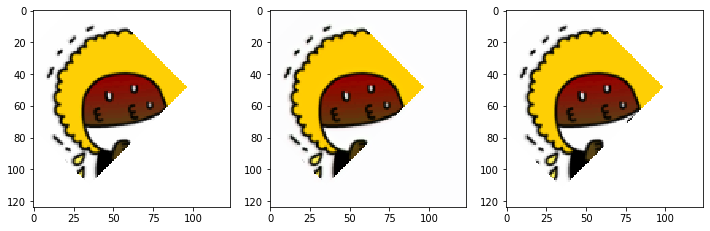

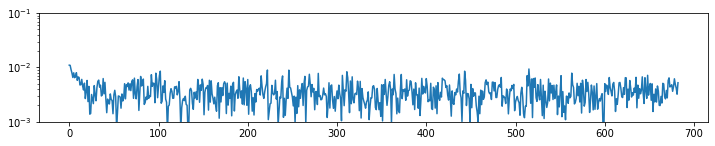

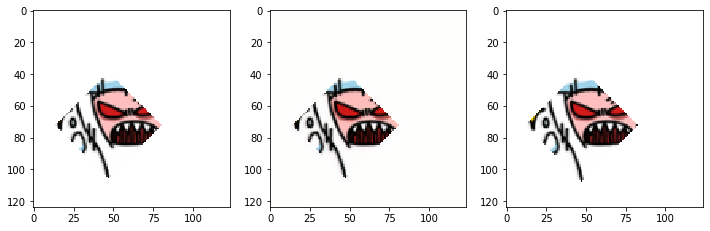

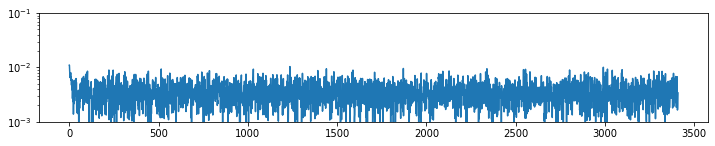

KeyboardInterrupt: 

In [19]:
for epoch in range(150):

    for i, batch in tqdm(enumerate(general_image_feeder.generator()), total=general_image_feeder.max_batch_num):

        batch_before, batch_after = batch

        optimizer.zero_grad()

        batch_pred = net(batch_before.to(device))
#         batch_pred = net(batch_pred) # 2 step prediction
#         batch_pred = net(batch_pred) # 3 step prediction
#         batch_pred = net(batch_pred) # 4 step prediction

        
        loss = criterion(batch_pred, batch_after.to(device))
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if i == general_image_feeder.max_batch_num // 2:
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(np.rollaxis(batch_before.numpy()[0], 0, 3))
            axes[1].imshow(np.clip(np.rollaxis(batch_pred.detach().cpu().numpy()[0], 0, 3), 0, 1))
            axes[2].imshow(np.rollaxis(batch_after.numpy()[0], 0, 3))
            plt.show()

            plt.figure(figsize=(12, 2))
            plt.plot(loss_history)
            plt.yscale('log')
            plt.ylim([1e-3, 1e-1])
            plt.show()